#1 - Introduction

* Topic : Commodity Prices Time Series Prediction Model
* Batch : FTDS RMT 27
* Group : 1
* Members :

#2 - Import Library

In [ ]:
# for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Modelling
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error,explained_variance_score,r2_score

# Others
from datetime import datetime

#3 - Data Loading

##3.1 - Load Data from xlsx File

In [ ]:
# Create list of dataframe
list_df = []

# create loop to load data from xlsx file
for i in range (1, 39):

    # Create dynamic variable and read file excel by variable loop
    globals()['df%s' %i] = pd.read_excel(f'https://raw.githubusercontent.com/FTDS-assignment-bay/p2-final-project-group-01-ftds-rmt-27/main/Dataset_Final_Project/export_eceran_({i}).xlsx')

    # get sheet_name per file xlsx
    sheet_name = map(str, pd.ExcelFile(f'https://raw.githubusercontent.com/FTDS-assignment-bay/p2-final-project-group-01-ftds-rmt-27/main/Dataset_Final_Project/export_eceran_({i}).xlsx').sheet_names)

    # convert Sheet name to String
    provinsi = ''.join(sheet_name)

    # add column Provinsi at first column with value sheet_name
    globals()['df%s' %i].insert(0, 'Provinsi', provinsi)

    # save dataframe to list
    list_df.append(globals()['df%s' %i])


In [ ]:
# Concate dataframe from df1 to df38
df = pd.concat(list_df, ignore_index=True)

# Drop Komoditas not in ['Beras Premium', 'Beras Medium', 'Bawang Merah', 'Bawang Putih Bonggol', 'Cabai Rawit Merah']
df = df[df[' Komoditas (Rp) '].isin(['Beras Premium', 'Beras Medium', 'Bawang Merah', 'Bawang Putih Bonggol', 'Cabai Rawit Merah'])].reset_index(drop=True)

In [ ]:
# Remove leading and traling whitespace from column names
df.columns = df.columns.str.strip()

In [ ]:
# Replace string '-' with NaN
df.replace('-', np.nan, inplace=True)

In [ ]:
df_melted = df.melt(id_vars=['Provinsi', 'Komoditas (Rp)'], var_name='Tanggal', value_name='Harga')

df_final = df_melted[['Tanggal', 'Provinsi', 'Komoditas (Rp)', 'Harga']]

df_final

,Tanggal,Provinsi,Komoditas (Rp),Harga
0,01/01/2023,Aceh,Beras Premium,12370.0
1,01/01/2023,Aceh,Beras Medium,11250.0
2,01/01/2023,Aceh,Bawang Merah,31930.0
3,01/01/2023,Aceh,Bawang Putih Bonggol,25040.0
4,01/01/2023,Aceh,Cabai Rawit Merah,NaN
...,...,...,...,...
80935,01/03/2024,Papua Selatan,Beras Premium,18000.0
80936,01/03/2024,Papua Selatan,Beras Medium,13900.0
80937,01/03/2024,Papua Selatan,Bawang Merah,55000.0
80938,01/03/2024,Papua Selatan,Bawang Putih Bonggol,45000.0


#4 - EDA

In [ ]:
# copy the dataset to keep original dataset before manipulation
df_final2 = df_final.copy()
# rename the column names
df_final2.rename(columns={'Komoditas (Rp)': 'Nama Komoditas', 'Harga': 'Harga (Rp)'}, inplace=True)

# show column names
df_final2.columns

Index(['Tanggal', 'Provinsi', 'Nama Komoditas', 'Harga (Rp)'], dtype='object')

##4.1 - Handle Missing Values

`Purpose`: to identify the number of missing values based on the provinces.

`Method`: remove the data for the provinces having significantly too much missing values.

In [ ]:
df_final2['Provinsi'].unique()

array(['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Jambi',
       'Sumatera Selatan', 'Bengkulu', 'Lampung',
       'Kepulauan Bangka Belitung', 'Kepulauan Riau', 'DKI Jakarta',
       'Jawa Barat', 'Jawa Tengah', 'D.I Yogyakarta', 'Jawa Timur',
       'Banten', 'Bali', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
       'Kalimantan Barat', 'Kalimantan Tengah', 'Kalimantan Selatan',
       'Kalimantan Timur', 'Kalimantan Utara', 'Sulawesi Utara',
       'Sulawesi Tengah', 'Sulawesi Selatan', 'Sulawesi Tenggara',
       'Gorontalo', 'Sulawesi Barat', 'Maluku', 'Maluku Utara',
       'Papua Barat', 'Papua', 'Papua Barat Daya', 'Papua Pegunungan',
       'Papua Tengah', 'Papua Selatan'], dtype=object)

In [ ]:
# Check missing value Data per Provinsi
df_final2['Provinsi'][(df_final2['Harga (Rp)'].isnull())].value_counts()

Papua Selatan                1950
Papua Pegunungan             1920
Papua Tengah                 1915
Papua Barat Daya             1910
Aceh                          372
DKI Jakarta                     5
Sulawesi Barat                  5
Bengkulu                        5
Kepulauan Bangka Belitung       5
Nusa Tenggara Barat             5
Kalimantan Timur                5
Kepulauan Riau                  5
Kalimantan Utara                5
Sumatera Utara                  1
Riau                            1
Sumatera Barat                  1
Name: Provinsi, dtype: int64

$Insight:$
- We will only use datas from province that has <= 5 missing values, so we will drop `Papua Selatan`, `Papua Pegunungan`, `Papua Tengah`, `Papua Barat Daya`, and `Aceh` from our `df_final`.
- This is to minimize underfitting our model, while also minimizing the amounts of data being dropped.
- Finally, since the rest of the data has minimal amounts of missing value, we will simply drop the leftover missing values.

In [ ]:
df_final2 = df_final2.drop(df_final[df_final['Provinsi'].isin(['Papua Selatan', 'Papua Pegunungan', 'Papua Tengah', 'Papua Barat Daya', 'Aceh'])].index)
df_final2 = df_final2.bfill()
df_final = df_final.bfill()

##4.2 - Feature Selection

`Purpose`: To get the data relevant for solving the problem.

`Method` : Selecting data based on domain knowledge, descriptive statistics, and visualizations.

###4.2.1 - Province

In [ ]:
# check the name of the available provinces on the dataset
list_of_provinces = df_final2['Provinsi'].unique().tolist()

# show the number of remaining provinces and the list of provinces names
print("Number of provinces: ", len(list_of_provinces))
print("Name of the provinces: ")
for i in range(len(list_of_provinces)):
    print(f'{i+1}. {list_of_provinces[i]}')

Number of provinces:  33
Name of the provinces: 
1. Sumatera Utara
2. Sumatera Barat
3. Riau
4. Jambi
5. Sumatera Selatan
6. Bengkulu
7. Lampung
8. Kepulauan Bangka Belitung
9. Kepulauan Riau
10. DKI Jakarta
11. Jawa Barat
12. Jawa Tengah
13. D.I Yogyakarta
14. Jawa Timur
15. Banten
16. Bali
17. Nusa Tenggara Barat
18. Nusa Tenggara Timur
19. Kalimantan Barat
20. Kalimantan Tengah
21. Kalimantan Selatan
22. Kalimantan Timur
23. Kalimantan Utara
24. Sulawesi Utara
25. Sulawesi Tengah
26. Sulawesi Selatan
27. Sulawesi Tenggara
28. Gorontalo
29. Sulawesi Barat
30. Maluku
31. Maluku Utara
32. Papua Barat
33. Papua


$Insight:$
- Since Rumah Makan Hati Tenteram restaurants are located only in Java Island, we believe that it's better to take data exclusively from the provinces in Java Island.
- The provinces in Java Island include:
  1. DKI Jakarta
  2. Jawa Barat
  3. Jawa Tengah
  4. D.I Yogyakarta
  5. Jawa Timur
  6. Banten

###4.2.2 - Commodity

In [ ]:
# check the commodity names available on the dataset
list_of_commodities = df_final2['Nama Komoditas'].unique().tolist()

# show the number of remaining provinces and the list of provinces names
print("Number of commodities available: ", len(list_of_commodities))
print("Name of the commodities: ")
for i in range(len(list_of_commodities)):
    print(f'{i+1}. {list_of_commodities[i]}')

Number of commodities available:  5
Name of the commodities: 
1. Beras Premium
2. Beras Medium
3. Bawang Merah
4. Bawang Putih Bonggol
5. Cabai Rawit Merah


$Insight:$
- There are five commodities available on the dataset: Beras Premium, Beras Medium, Bawang Merah, Bawang Putih Bonggol, and Cabai Rawit Merah.

- Since Rumah Makan Hati Tenteram restaurants sell rice-based dishes, beras is definitely a major part for defining the cost of goods sold.

- There are two types of rice commodities: Beras Premium and Beras Medium.

- The restaurant is using Beras Premium in their business since it is known for better quality (whiter appearance, no broken rice grains, and clean from dirts).

- You can access reference about rice quality difference [here](https://www.kompas.id/baca/kompas_multimedia/antara-beras-premium-dan-beras-medium) !

##4.3 - Price Variation for Beras Premium and Beras Medium in Each Province

`Purpose`: See the price data distribution for the commodities based on the provinces.

`Method` : Box Plot and Descriptive Statistics.

In [ ]:
# get data only for provinces in Java Island
java_island_provinces = ['DKI Jakarta', 'Jawa Barat', 'Jawa Tengah', 'D.I Yogyakarta', 'Jawa Timur', 'Banten']

# Filter dataset for the specified provinces
provinces_data = df_final2[df_final2['Provinsi'].isin(java_island_provinces)].reset_index(drop=True)

# show result
provinces_data.head()

,Tanggal,Provinsi,Nama Komoditas,Harga (Rp)
0,01/01/2023,DKI Jakarta,Beras Premium,12860.0
1,01/01/2023,DKI Jakarta,Beras Medium,10600.0
2,01/01/2023,DKI Jakarta,Bawang Merah,39370.0
3,01/01/2023,DKI Jakarta,Bawang Putih Bonggol,30240.0
4,01/01/2023,DKI Jakarta,Cabai Rawit Merah,56250.0


In [ ]:
# compare Beras Premium and Beras Medium descriptive statistical results
beras_premium_df = provinces_data[provinces_data['Nama Komoditas']=='Beras Premium']

# see descriptive statistical results
beras_premium_df.describe()

,Harga (Rp)
count,2556.000000
mean,13415.833333
std,1043.918766
min,11660.000000
25%,12620.000000
50%,12840.000000
75%,14100.000000
max,17220.000000


$Insight:$

- Based on descriptive statistical study, the average price of Beras Premium is 13417 IDR.
- The spread of the data for both Beras Premium is represented by its standard deviation, at 1044 IDR.
- The range of the prices of Beras Premium starts from 11660 IDR to 17220 IDR.

In [ ]:
# create function for making boxplot
def boxplot_maker(dataset,commodity_type):
    # Prepare the plot
    plt.figure(figsize=(10, 6))  # Adjust figure size if needed

    # Create a boxplot using seaborn
    sns.boxplot(x='Provinsi', y='Harga (Rp)', data=dataset, hue='Provinsi', palette='Pastel1', legend=False)

    # Calculate median values
    medians = dataset.groupby(['Provinsi'])['Harga (Rp)'].median()

    # Sort medians based on the order of categories in the x-axis
    categories = dataset['Provinsi'].unique()
    medians = medians.reindex(categories)

    # Add median annotations to the plot
    for i, median in enumerate(medians):
        plt.text(i, median + 5, f'{median:.2f}', horizontalalignment='center', verticalalignment='bottom', fontdict={'color': 'black'})

    # Add title
    plt.title(f'BOXPLOT OF {commodity_type.upper()} PRICES IN PROVINCES FROM JAVA ISLAND')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()



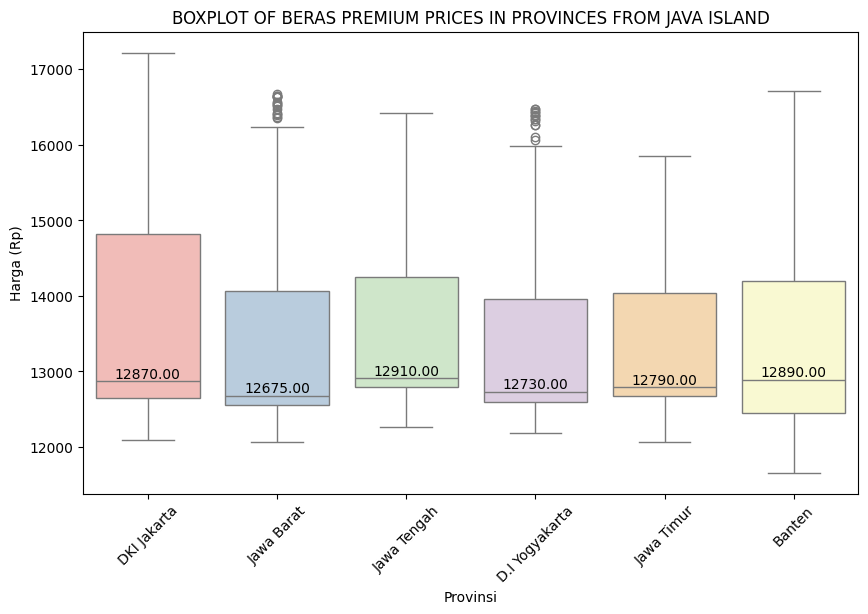

In [ ]:
# show result for Beras Premium Box Plot
boxplot_maker(beras_premium_df,'beras premium')

$Insight:$

- Based on the boxplot of Beras Premium, we can see some outliers from Jawa Barat and D.I Yogyakarta. On the other hand, it is important to let the outliers as it is to keep the data originality.

- In general, the median prices in Beras Premium are ranging from 12675 IDR to 12910 IDR.

1. DKI Jakarta

Among the provinces, DKI Jakarta has the largest price variations for Beras Premium. The price starts from around 12300 IDR to 17200 IDR, with median price at 12870 IDR.

2. Jawa Barat

Jawa Barat's Beras Premium has the price ranging from around 12100 IDR to 16500 IDR, with the lowest median price compared to other provinces, at 12675 IDR .

3. Jawa Tengah

In Jawa Tengah, Beras Premium has the price ranging from around 12250 IDR to 16250 IDR, with the highest median price compared to other provinces, at 12790 IDR.

4. D.I Yogyakarta

In D.I Yogyakarta, Beras Premium has the price ranging from around 12250 IDR to 16500 IDR, with the median price at 12730 IDR.

5. Jawa Timur

Jawa Timur has least price variations for Beras Premium (shown by shortest box and whiskers plot). Its price us ranging from around 12100 IDR to 16000 IDR, with the median price at 12730 IDR.

6. Banten

Lastly, Banten's Beras Premium has the price ranging from around 11750 IDR to 16750 IDR, with the median price at 12890 IDR.


In [ ]:
# save the csv file for deployment on EDA section
beras_premium_df.to_csv('beras_premium_pulau_jawa.csv',index = False)

## 4.4 Time Series Of Beras Premium Price

### 4.4.1 DKI Jakarta

<ipython-input-18-28059009b7d8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jakarta['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')
<ipython-input-18-28059009b7d8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jakarta.sort_values(by='Tanggal', inplace=True)


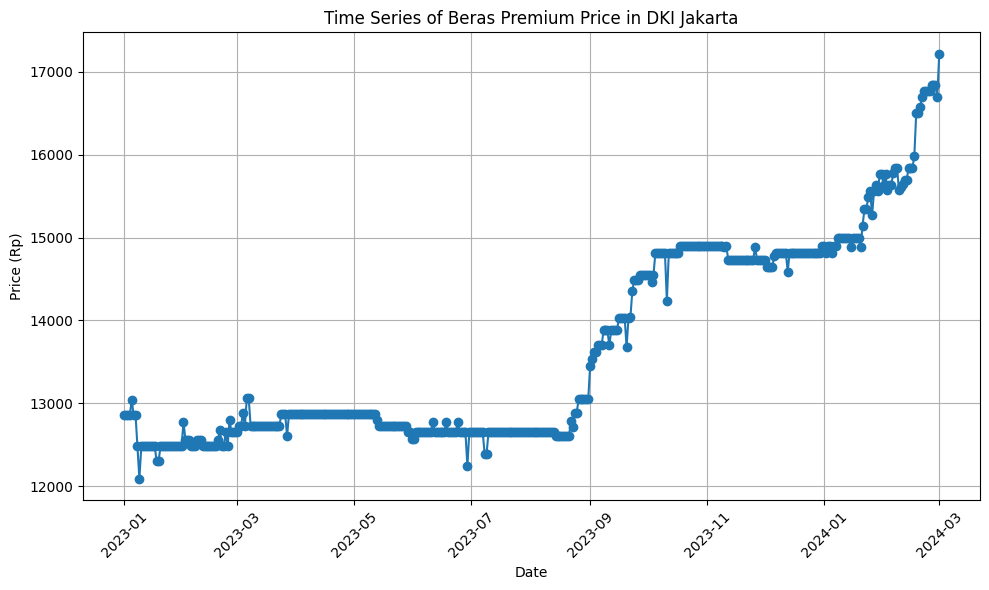

In [ ]:
# Filter data for Beras Premium in DKI Jakarta
beras_premium_data_jakarta = df_final[(df_final['Komoditas (Rp)'] == 'Beras Premium') & (df_final['Provinsi'] == 'DKI Jakarta')]

# Convert the 'Tanggal' column to datetime format
beras_premium_data_jakarta['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')

# Sort the data by date
beras_premium_data_jakarta.sort_values(by='Tanggal', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(beras_premium_data_jakarta['Tanggal'], beras_premium_data_jakarta['Harga'], marker='o', linestyle='-')
plt.title('Time Series of Beras Premium Price in DKI Jakarta')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# table average price per month

# Extract year and month
beras_premium_data_jakarta['Year'] = beras_premium_data_jakarta['Tanggal'].dt.year
beras_premium_data_jakarta['Month'] = beras_premium_data_jakarta['Tanggal'].dt.month

# Group by year and month, calculate average price
average_price_per_month_year = beras_premium_data_jakarta.groupby(['Year', 'Month'])['Harga'].mean().reset_index()

# Display the resulting table
print(average_price_per_month_year)

    Year  Month         Harga
0   2023      1  12547.419355
1   2023      2  12553.571429
2   2023      3  12781.290323
3   2023      4  12870.000000
4   2023      5  12776.129032
5   2023      6  12646.666667
6   2023      7  12633.225806
7   2023      8  12739.354839
8   2023      9  14002.666667
9   2023     10  14795.806452
10  2023     11  14797.333333
11  2023     12  14789.032258
12  2024      1  15140.322581
13  2024      2  16136.896552
14  2024      3  17220.000000


<ipython-input-19-39ad1a763821>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jakarta['Year'] = beras_premium_data_jakarta['Tanggal'].dt.year
<ipython-input-19-39ad1a763821>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jakarta['Month'] = beras_premium_data_jakarta['Tanggal'].dt.month


**Insight:**
- Based on the graph of the price of premium rice in Jakarta, there is a noticeable upward trend in rice prices.
- The price increase occurred in September 2023, from average price 12.739 IDR to 14.002 IDR, and remained relatively stable until the end of 2023.
- Another increase occurred at the beginning of 2024, reaching its peak price on March 1st at 17.220 IDR per kilogram.

### 4.4.2 Jawa Barat

<ipython-input-20-47710c223405>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jabar['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')
<ipython-input-20-47710c223405>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jabar.sort_values(by='Tanggal', inplace=True)


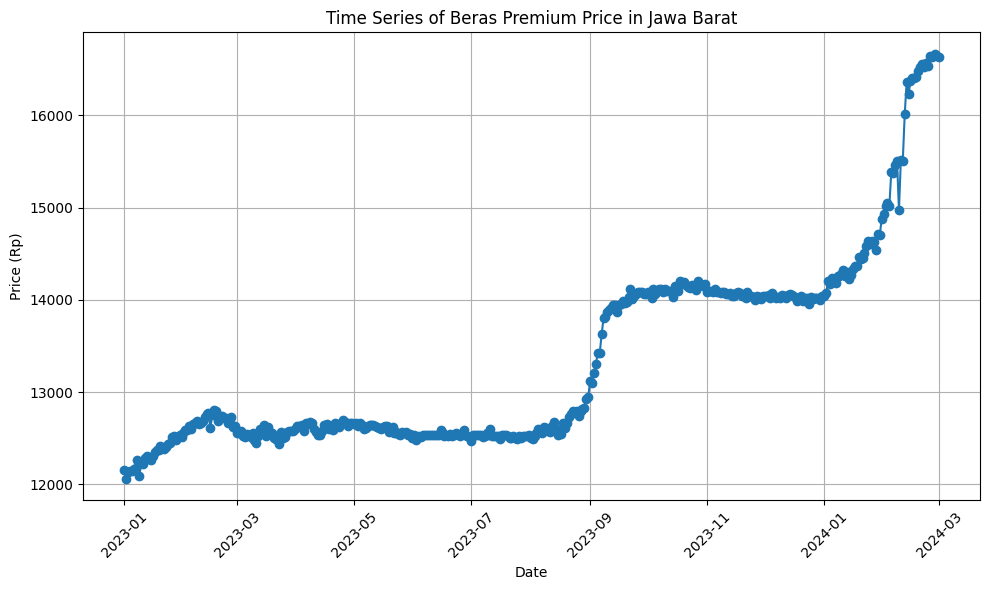

In [ ]:
# Filter data for Beras Premium in Jawa Barat
beras_premium_data_jabar = df_final[(df_final['Komoditas (Rp)'] == 'Beras Premium') & (df_final['Provinsi'] == 'Jawa Barat')]

# Convert the 'Tanggal' column to datetime format
beras_premium_data_jabar['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')

# Sort the data by date
beras_premium_data_jabar.sort_values(by='Tanggal', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(beras_premium_data_jabar['Tanggal'], beras_premium_data_jabar['Harga'], marker='o', linestyle='-')
plt.title('Time Series of Beras Premium Price in Jawa Barat')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# table average price per month

# Extract year and month
beras_premium_data_jabar['Year'] = beras_premium_data_jabar['Tanggal'].dt.year
beras_premium_data_jabar['Month'] = beras_premium_data_jabar['Tanggal'].dt.month

# Group by year and month, calculate average price
average_price_per_month_year = beras_premium_data_jabar.groupby(['Year', 'Month'])['Harga'].mean().reset_index()

# Display the resulting table
print(average_price_per_month_year)

    Year  Month         Harga
0   2023      1  12319.032258
1   2023      2  12685.357143
2   2023      3  12542.580645
3   2023      4  12630.333333
4   2023      5  12600.000000
5   2023      6  12535.000000
6   2023      7  12521.935484
7   2023      8  12664.193548
8   2023      9  13823.000000
9   2023     10  14124.838710
10  2023     11  14061.000000
11  2023     12  14027.096774
12  2024      1  14392.258065
13  2024      2  16013.103448
14  2024      3  16630.000000


<ipython-input-21-14e66996b642>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jabar['Year'] = beras_premium_data_jabar['Tanggal'].dt.year
<ipython-input-21-14e66996b642>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jabar['Month'] = beras_premium_data_jabar['Tanggal'].dt.month


**Insight:**
- In 2023, the average price of premium rice in West Java remained stable around 12,500 IDR until August 2023.
- There was a price increase in September 2023, followed by stabilization at an average price of 14,000 IDR.
- Prices rose again at the beginning of 2024, especially in February, with the average price of premium rice reaching 16,000 IDR per kilogram

### 4.4.3 Jawa Tengah

<ipython-input-22-4527c686f1a8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jateng['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')
<ipython-input-22-4527c686f1a8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jateng.sort_values(by='Tanggal', inplace=True)


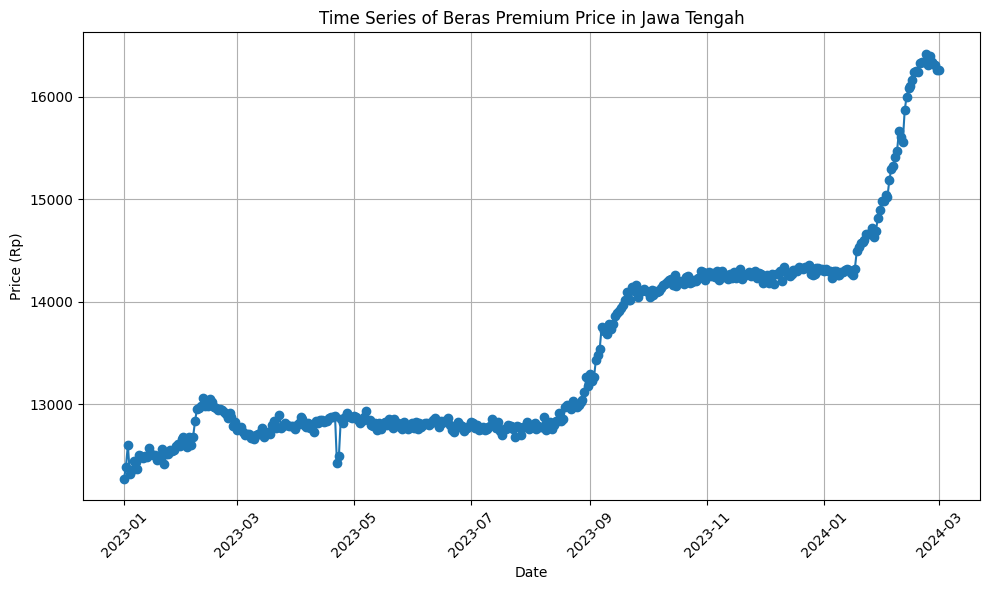

In [ ]:
# Filter data for Beras Premium in Jawa Tengah
beras_premium_data_jateng = df_final[(df_final['Komoditas (Rp)'] == 'Beras Premium') & (df_final['Provinsi'] == 'Jawa Tengah')]

# Convert the 'Tanggal' column to datetime format
beras_premium_data_jateng['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')

# Sort the data by date
beras_premium_data_jateng.sort_values(by='Tanggal', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(beras_premium_data_jateng['Tanggal'], beras_premium_data_jateng['Harga'], marker='o', linestyle='-')
plt.title('Time Series of Beras Premium Price in Jawa Tengah')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# table average price per month

# Extract year and month
beras_premium_data_jateng['Year'] = beras_premium_data_jateng['Tanggal'].dt.year
beras_premium_data_jateng['Month'] = beras_premium_data_jateng['Tanggal'].dt.month

# Group by year and month, calculate average price
average_price_per_month_year = beras_premium_data_jateng.groupby(['Year', 'Month'])['Harga'].mean().reset_index()

# Display the resulting table
print(average_price_per_month_year)

    Year  Month         Harga
0   2023      1  12489.677419
1   2023      2  12873.928571
2   2023      3  12750.967742
3   2023      4  12808.000000
4   2023      5  12815.161290
5   2023      6  12798.333333
6   2023      7  12774.193548
7   2023      8  12903.870968
8   2023      9  13831.666667
9   2023     10  14177.741935
10  2023     11  14261.333333
11  2023     12  14284.516129
12  2024      1  14465.483871
13  2024      2  15891.724138
14  2024      3  16260.000000


<ipython-input-23-1ffc937949d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jateng['Year'] = beras_premium_data_jateng['Tanggal'].dt.year
<ipython-input-23-1ffc937949d0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jateng['Month'] = beras_premium_data_jateng['Tanggal'].dt.month


**Insight:**
- In 2023, the average price of premium rice in Center Java remained stable around 12,800 IDR until August 2023.
- There was a price increase in September 2023, followed by stabilization at an average price of 14,100 IDR.
- Prices rose again at the beginning of 2024, especially in February, with the average price of premium rice reaching 15891 IDR per kilogram.

### 4.4.4 Yogyakarta

<ipython-input-24-92c10d32fad2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_yogya['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')
<ipython-input-24-92c10d32fad2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_yogya.sort_values(by='Tanggal', inplace=True)


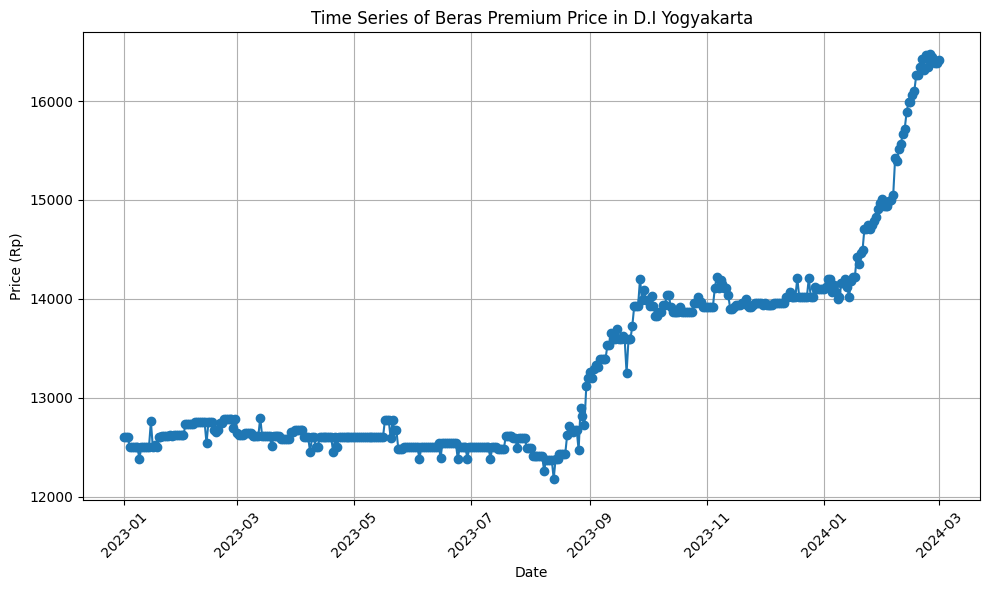

In [ ]:
# Filter data for Beras Premium in D.I Yogyakarta
beras_premium_data_yogya = df_final[(df_final['Komoditas (Rp)'] == 'Beras Premium') & (df_final['Provinsi'] == 'D.I Yogyakarta')]

# Convert the 'Tanggal' column to datetime format
beras_premium_data_yogya['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')

# Sort the data by date
beras_premium_data_yogya.sort_values(by='Tanggal', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(beras_premium_data_yogya['Tanggal'], beras_premium_data_yogya['Harga'], marker='o', linestyle='-')
plt.title('Time Series of Beras Premium Price in D.I Yogyakarta')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# table average price per month

# Extract year and month
beras_premium_data_yogya['Year'] = beras_premium_data_yogya['Tanggal'].dt.year
beras_premium_data_yogya['Month'] = beras_premium_data_yogya['Tanggal'].dt.month

# Group by year and month, calculate average price
average_price_per_month_year = beras_premium_data_yogya.groupby(['Year', 'Month'])['Harga'].mean().reset_index()

# Display the resulting table
print(average_price_per_month_year)

    Year  Month         Harga
0   2023      1  12562.258065
1   2023      2  12728.571429
2   2023      3  12618.387097
3   2023      4  12589.333333
4   2023      5  12598.387097
5   2023      6  12496.333333
6   2023      7  12524.193548
7   2023      8  12534.193548
8   2023      9  13604.666667
9   2023     10  13919.032258
10  2023     11  13989.333333
11  2023     12  14023.548387
12  2024      1  14389.032258
13  2024      2  15851.034483
14  2024      3  16420.000000


<ipython-input-25-52f2740e83fe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_yogya['Year'] = beras_premium_data_yogya['Tanggal'].dt.year
<ipython-input-25-52f2740e83fe>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_yogya['Month'] = beras_premium_data_yogya['Tanggal'].dt.month


**Insight:**
- In 2023, the average price of premium rice in D.I Yogyakarta remained stable around 12,500 IDR until August 2023.
- There was a sharp price increase in September 2023, which continued to rise gradually until the end of the year, reaching an average price of 14,000 IDR in December.
- Prices then surged again in February 2024, with the average price of premium rice reaching 15,851 IDR.

### 4.4.5 Jawa Timur

<ipython-input-26-97940da8e5db>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jatim['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')
<ipython-input-26-97940da8e5db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jatim.sort_values(by='Tanggal', inplace=True)


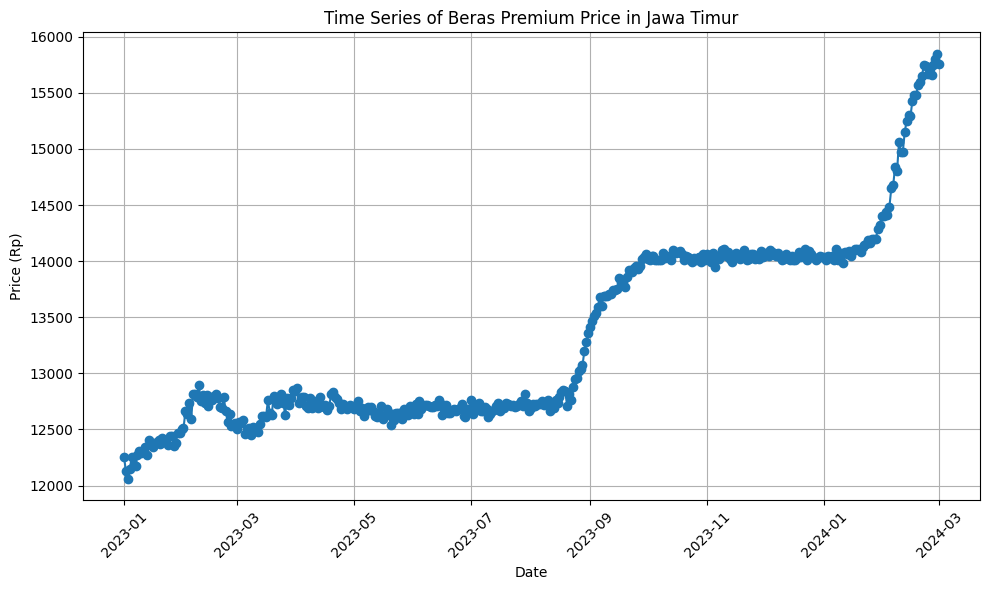

In [ ]:
# Filter data for Beras Premium in Jawa Timur
beras_premium_data_jatim = df_final[(df_final['Komoditas (Rp)'] == 'Beras Premium') & (df_final['Provinsi'] == 'Jawa Timur')]

# Convert the 'Tanggal' column to datetime format
beras_premium_data_jatim['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')

# Sort the data by date
beras_premium_data_jatim.sort_values(by='Tanggal', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(beras_premium_data_jatim['Tanggal'], beras_premium_data_jatim['Harga'], marker='o', linestyle='-')
plt.title('Time Series of Beras Premium Price in Jawa Timur')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

**Insight:**
- In 2023, the average price of premium rice in East java remained stable around 12,600 IDR until August 2023.
- There was a sharp price increase in September 2023, but remained stable with an average price of 14,000 IDR until December.
- Prices then surged again in February 2024, with the average price of premium rice reaching 15,200 IDR.
- Even though in East Java, on March 1st, the price has not reached 16,000 IDR, unlike other provinces in Java Island that have reached figures above 16,000

In [ ]:
# table average price per month

# Extract year and month
beras_premium_data_jatim['Year'] = beras_premium_data_jatim['Tanggal'].dt.year
beras_premium_data_jatim['Month'] = beras_premium_data_jatim['Tanggal'].dt.month

# Group by year and month, calculate average price
average_price_per_month_year = beras_premium_data_jatim.groupby(['Year', 'Month'])['Harga'].mean().reset_index()

# Display the resulting table
print(average_price_per_month_year)

    Year  Month         Harga
0   2023      1  12331.935484
1   2023      2  12711.428571
2   2023      3  12637.419355
3   2023      4  12739.000000
4   2023      5  12654.838710
5   2023      6  12688.333333
6   2023      7  12701.612903
7   2023      8  12846.451613
8   2023      9  13775.000000
9   2023     10  14035.806452
10  2023     11  14042.333333
11  2023     12  14047.419355
12  2024      1  14114.838710
13  2024      2  15235.517241
14  2024      3  15760.000000


<ipython-input-27-e8b79d44b131>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jatim['Year'] = beras_premium_data_jatim['Tanggal'].dt.year
<ipython-input-27-e8b79d44b131>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_jatim['Month'] = beras_premium_data_jatim['Tanggal'].dt.month


### 4.4.6 Banten

<ipython-input-28-eb87773f541f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_banten['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')
<ipython-input-28-eb87773f541f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_banten.sort_values(by='Tanggal', inplace=True)


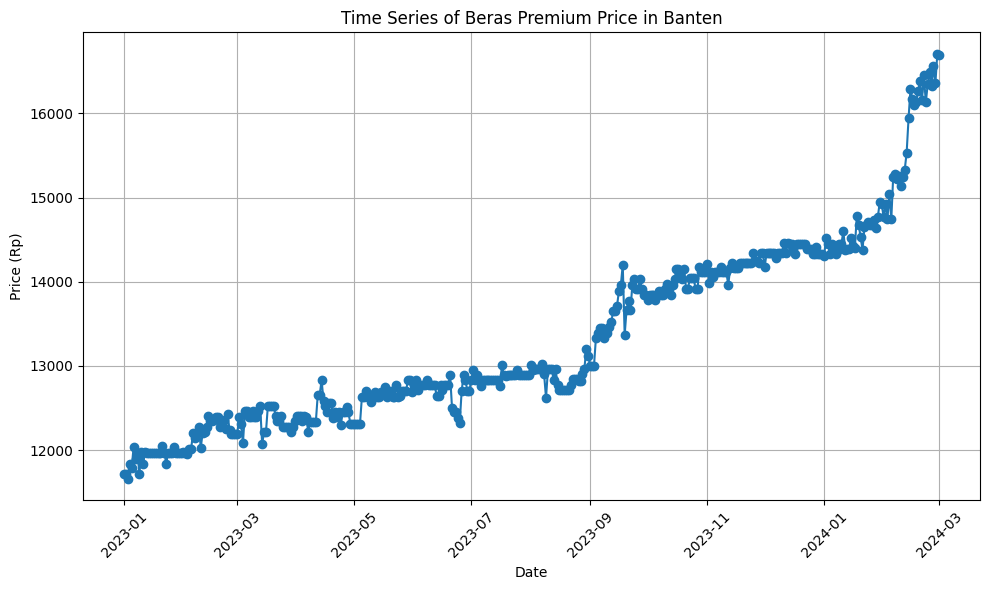

In [ ]:
# Filter data for Beras Premium in Banten
beras_premium_data_banten = df_final[(df_final['Komoditas (Rp)'] == 'Beras Premium') & (df_final['Provinsi'] == 'Banten')]

# Convert the 'Tanggal' column to datetime format
beras_premium_data_banten['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')

# Sort the data by date
beras_premium_data_banten.sort_values(by='Tanggal', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(beras_premium_data_banten['Tanggal'], beras_premium_data_banten['Harga'], marker='o', linestyle='-')
plt.title('Time Series of Beras Premium Price in Banten')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# table average price per month

# Extract year and month
beras_premium_data_banten['Year'] = beras_premium_data_banten['Tanggal'].dt.year
beras_premium_data_banten['Month'] = beras_premium_data_banten['Tanggal'].dt.month

# Group by year and month, calculate average price
average_price_per_month_year = beras_premium_data_banten.groupby(['Year', 'Month'])['Harga'].mean().reset_index()

# Display the resulting table
print(average_price_per_month_year)

    Year  Month         Harga
0   2023      1  11922.258065
1   2023      2  12222.857143
2   2023      3  12353.548387
3   2023      4  12441.333333
4   2023      5  12629.354839
5   2023      6  12706.000000
6   2023      7  12865.806452
7   2023      8  12876.451613
8   2023      9  13622.333333
9   2023     10  13968.064516
10  2023     11  14179.333333
11  2023     12  14372.258065
12  2024      1  14545.806452
13  2024      2  15768.620690
14  2024      3  16690.000000


<ipython-input-29-7b8288a8a933>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_banten['Year'] = beras_premium_data_banten['Tanggal'].dt.year
<ipython-input-29-7b8288a8a933>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data_banten['Month'] = beras_premium_data_banten['Tanggal'].dt.month


**Insight:**
- Overall, the increase in premium rice prices in Banten Province shows a consistent upward trend from the beginning of January 2023 until March 1st, 2024.
- From the price increase graph, the most drastic increases occurred in September 2023 and February 2024.
- Premium rice prices in Banten reached 16,690 IDR on March 1st, 2024, whereas in January 2023, the average price was only 11,922 IDR.

### 4.4.7 All Provinces in Java Island

<ipython-input-30-32dbefa6d03f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')
<ipython-input-30-32dbefa6d03f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beras_premium_data.sort_values(by='Tanggal', inplace=True)


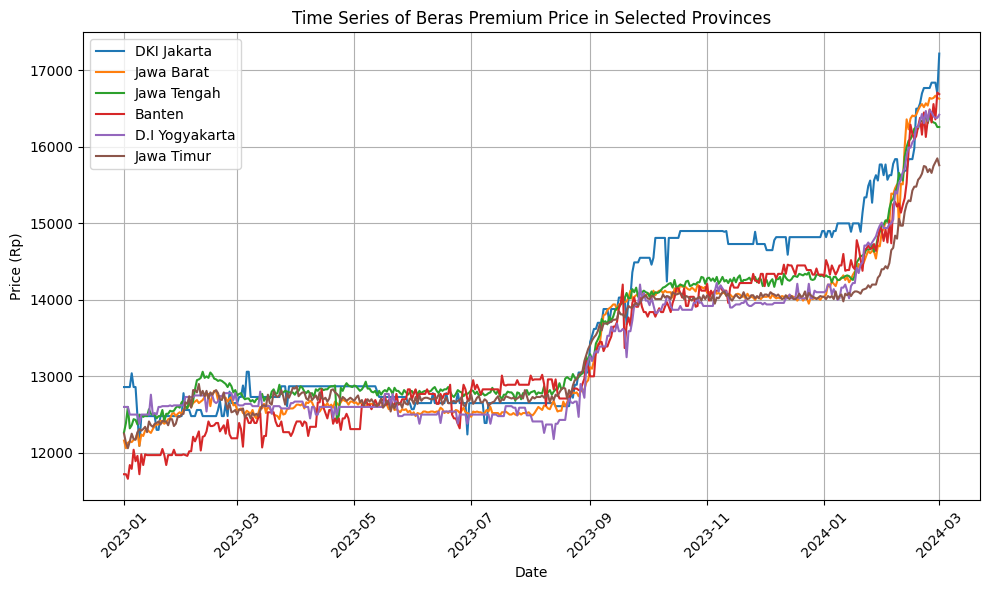

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your data in a DataFrame named 'df_final'
# If not, you can read your data into a DataFrame using pandas read_csv function
# Example: df_final = pd.read_csv('your_dataset.csv')

# Filter data for Beras Premium in selected provinces
selected_provinces = ['DKI Jakarta', 'Jawa Barat', 'Jawa Tengah', 'Banten', 'D.I Yogyakarta', 'Jawa Timur']
beras_premium_data = df_final[(df_final['Komoditas (Rp)'] == 'Beras Premium') & (df_final['Provinsi'].isin(selected_provinces))]

# Convert the 'Tanggal' column to datetime format
beras_premium_data['Tanggal'] = pd.to_datetime(df_final['Tanggal'], format='%d/%m/%Y')

# Sort the data by date
beras_premium_data.sort_values(by='Tanggal', inplace=True)

# Plot
plt.figure(figsize=(10, 6))

for province in selected_provinces:
    province_data = beras_premium_data[beras_premium_data['Provinsi'] == province]
    plt.plot(province_data['Tanggal'], province_data['Harga'], linestyle='-', label=province)

plt.title('Time Series of Beras Premium Price in Selected Provinces')
plt.xlabel('Date')
plt.ylabel('Price (Rp)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
# Table

# Extract year and month
beras_premium_data['Year'] = beras_premium_data['Tanggal'].dt.year
beras_premium_data['Month'] = beras_premium_data['Tanggal'].dt.month

# Group by year and month, calculate average price
average_price_per_month_year = beras_premium_data.groupby(['Year', 'Month'])['Harga'].mean().reset_index()

# Display the resulting table
print(average_price_per_month_year)

    Year  Month         Harga
0   2023      1  12362.096774
1   2023      2  12629.285714
2   2023      3  12614.032258
3   2023      4  12679.666667
4   2023      5  12678.978495
5   2023      6  12645.111111
6   2023      7  12670.161290
7   2023      8  12760.752688
8   2023      9  13776.555556
9   2023     10  14170.215054
10  2023     11  14221.777778
11  2023     12  14257.311828
12  2024      1  14507.956989
13  2024      2  15816.149425
14  2024      3  16496.666667


<ipython-input-377-ab11a127a044>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-377-ab11a127a044>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Insight** :
- The price of premium rice in Java Island at the beginning of 2023 remained stable in the range of 12,000 - 13,000 IDR per kilogram, with an average around 12,600 IDR per kilogram.
- The increase in rice prices in Java Island occurred around August and September 2023, with prices ranging from 14,000 - 14,800 IDR per kilogram.
- Subsequently, the prices stabilized until rising again at the beginning of 2024, reaching a price of 17,220 IDR per kilogram in March 1st. One of the causes for this could be attributed to the rice scarcity among the public and resulting in a price surge to its peak.

---

#5 - Feature Engineering

Based on our previous EDA, we will now use:
- Province : `'DKI Jakarta', 'Jawa Barat', 'Jawa Tengah', 'D.I Yogyakarta', 'Jawa Timur', 'Banten'`
- Commodity : `'Beras Premium','Beras Medium'`.

## 5.1 - Split into Different Provinces

In [ ]:
# Create dataframes grouped by "Provinsi"
df_jakarta = df_final[df_final['Provinsi'] == 'DKI Jakarta']
df_jawa_barat = df_final[df_final['Provinsi'] == 'Jawa Barat']
df_jawa_tengah = df_final[df_final['Provinsi'] == 'Jawa Tengah']
df_yogyakarta = df_final[df_final['Provinsi'] == 'D.I Yogyakarta']
df_jawa_timur = df_final[df_final['Provinsi'] == 'Jawa Timur']
df_banten = df_final[df_final['Provinsi'] == 'Banten']

##5.2 - Split Into Different Commodities

###5.2.1 - Beras Premium

In [ ]:
# Create dataframes grouped by "Komoditas (Rp)"
df_beras_premium_jakarta = df_jakarta[df_jakarta['Komoditas (Rp)'] == 'Beras Premium']
df_beras_premium_jawa_barat = df_jawa_barat[df_jawa_barat['Komoditas (Rp)'] == 'Beras Premium']
df_beras_premium_jawa_tengah = df_jawa_tengah[df_jawa_tengah['Komoditas (Rp)'] == 'Beras Premium']
df_beras_premium_yogyakarta = df_yogyakarta[df_yogyakarta['Komoditas (Rp)'] == 'Beras Premium']
df_beras_premium_jawa_timur = df_jawa_timur[df_jawa_timur['Komoditas (Rp)'] == 'Beras Premium']
df_beras_premium_banten = df_banten[df_banten['Komoditas (Rp)'] == 'Beras Premium']

###5.2.2 - Beras Medium

In [ ]:
# Create dataframes grouped by "Komoditas (Rp)"
df_beras_medium_jakarta = df_jakarta[df_jakarta['Komoditas (Rp)'] == 'Beras Medium']
df_beras_medium_jawa_barat = df_jawa_barat[df_jawa_barat['Komoditas (Rp)'] == 'Beras Medium']
df_beras_medium_jawa_tengah = df_jawa_tengah[df_jawa_tengah['Komoditas (Rp)'] == 'Beras Medium']
df_beras_medium_yogyakarta = df_yogyakarta[df_yogyakarta['Komoditas (Rp)'] == 'Beras Medium']
df_beras_medium_jawa_timur = df_jawa_timur[df_jawa_timur['Komoditas (Rp)'] == 'Beras Medium']
df_beras_medium_banten = df_banten[df_banten['Komoditas (Rp)'] == 'Beras Medium']

##5.3 - Preprocessing and Exporting Each Dataframes

###5.3.1 - DKI Jakarta

In [ ]:
df_beras_premium_jakarta['Tanggal'] = pd.to_datetime(df_beras_premium_jakarta['Tanggal'], format="%d/%m/%Y")
jakarta_premium = df_beras_premium_jakarta.set_index('Tanggal')['Harga']

<class 'pandas.core.series.Series'>
DatetimeIndex: 426 entries, 2023-01-01 to 2024-03-01
Series name: Harga
Non-Null Count  Dtype  
--------------  -----  
426 non-null    float64
dtypes: float64(1)
memory usage: 6.7 KB


<ipython-input-464-1d33e78dc6b1>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Tanggal'>

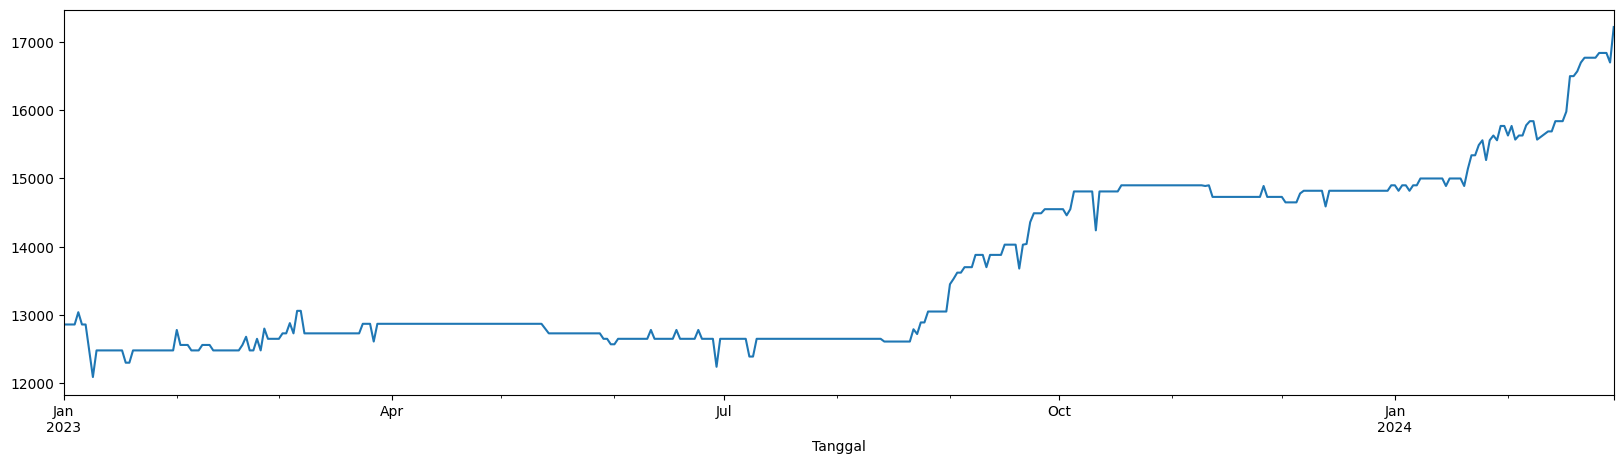

In [ ]:
jakarta_premium.plot(figsize=(20,5))

In [ ]:
jakarta_premium.to_csv('jakarta_premium.csv')

###5.3.2 - Jawa Barat

In [ ]:
df_beras_premium_jawa_barat['Tanggal'] = pd.to_datetime(df_beras_premium_jawa_barat['Tanggal'], format="%d/%m/%Y")
jawa_barat_premium = df_beras_premium_jawa_barat.set_index('Tanggal')['Harga']
jawa_barat_premium.head()

<ipython-input-384-b850118b7d5b>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Tanggal
2023-01-01    12160.0
2023-01-02    12060.0
2023-01-03    12130.0
2023-01-04    12150.0
2023-01-05    12140.0
Name: Harga, dtype: float64

In [ ]:
jawa_barat_premium.to_csv('jawa_barat_premium.csv')

###5.3.3 - Jawa Tengah

In [ ]:
df_beras_medium_jawa_tengah['Tanggal'] = pd.to_datetime(df_beras_medium_jawa_tengah['Tanggal'], format="%d/%m/%Y")
jawa_tengah_premium = df_beras_medium_jawa_tengah.set_index('Tanggal')['Harga']
jawa_tengah_premium.head()

<ipython-input-386-e454d4ce95b9>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Tanggal
2023-01-01    10780.0
2023-01-02    10970.0
2023-01-03    10960.0
2023-01-04    10870.0
2023-01-05    10970.0
Name: Harga, dtype: float64

In [ ]:
jawa_tengah_premium.to_csv('jawa_tengah_premium.csv')

###5.3.4 - D.I Yogyakarta

In [ ]:
df_beras_premium_yogyakarta['Tanggal'] = pd.to_datetime(df_beras_premium_yogyakarta['Tanggal'], format="%d/%m/%Y")
yogyakarta_premium = df_beras_premium_yogyakarta.set_index('Tanggal')['Harga']
yogyakarta_premium.head()

<ipython-input-388-dd187856e2f3>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Tanggal
2023-01-01    12600.0
2023-01-02    12600.0
2023-01-03    12600.0
2023-01-04    12500.0
2023-01-05    12500.0
Name: Harga, dtype: float64

In [ ]:
yogyakarta_premium.to_csv('yogyakarta_premium.csv')

###5.3.5 - Jawa Timur

In [ ]:
df_beras_premium_jawa_timur['Tanggal'] = pd.to_datetime(df_beras_premium_jawa_timur['Tanggal'], format="%d/%m/%Y")
jawa_timur_premium = df_beras_premium_jawa_timur.set_index('Tanggal')['Harga']
jawa_timur_premium.head()

<ipython-input-390-58f1f487779d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Tanggal
2023-01-01    12250.0
2023-01-02    12130.0
2023-01-03    12060.0
2023-01-04    12150.0
2023-01-05    12250.0
Name: Harga, dtype: float64

In [ ]:
jawa_timur_premium.to_csv('jawa_timur_premium.csv')

###5.3.6 - Banten

In [ ]:
df_beras_premium_banten['Tanggal'] = pd.to_datetime(df_beras_premium_banten['Tanggal'], format="%d/%m/%Y")
banten_premium = df_beras_premium_banten.set_index('Tanggal')['Harga']
banten_premium.head()

<ipython-input-392-5348f1b393e5>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Tanggal
2023-01-01    11720.0
2023-01-02    11720.0
2023-01-03    11660.0
2023-01-04    11840.0
2023-01-05    11790.0
Name: Harga, dtype: float64

In [ ]:
banten_premium.to_csv('banten_premium.csv')

#6 - Model Prototyping with `DKI Jakarta Beras Premium` Dataframe

In [ ]:
import numpy as np

window = 10
X = []
y = []
for i in range(window,len(jakarta_premium)):
  if window+i<len(jakarta_premium):
    X.append(jakarta_premium[i:window+i].values.tolist())
    try:
      y.append(jakarta_premium[window+i])
    except:
      pass
  else:
    break

X = np.array(X)
y = np.array(y)

In [ ]:
train_size = round(len(X)*0.85)
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

<Axes: xlabel='Tanggal'>

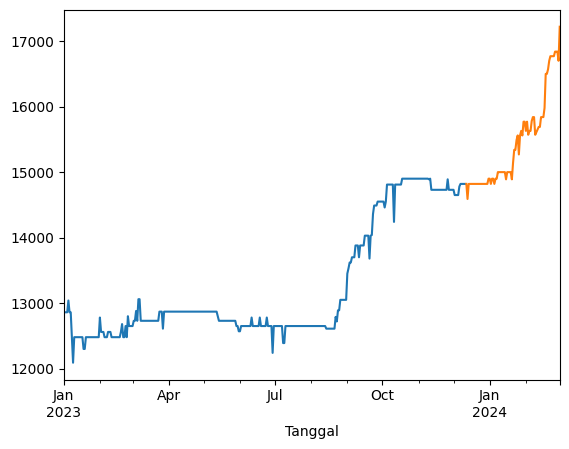

In [ ]:
jakarta_premium[:train_size].plot()
jakarta_premium[train_size:].plot()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##6.1 - Linear Regression

###6.1.1 - Model Definition

In [ ]:
model_lr = LinearRegression(fit_intercept=True)

In [ ]:
model_lr

LinearRegression()

###6.1.2 - Model Training

In [ ]:
model_lr.fit(X_train_scaled,y_train)

y_pred_train = model_lr.predict(X_train_scaled)
y_pred_test = model_lr.predict(X_test_scaled)

###6.1.3 - Model Evaluation

In [ ]:
print('Train MAE:',mean_absolute_error(y_train,y_pred_train))
print('Train RMSE:',mean_squared_error(y_train,y_pred_train, squared=False))
print('-----------------------------------------------------')
print('Test MAE:',mean_absolute_error(y_test,y_pred_test))
print('Test RMSE:',mean_squared_error(y_test,y_pred_test, squared=False))

Train MAE: 46.69821526858829
Train RMSE: 88.20628056482451
-----------------------------------------------------
Test MAE: 96.43399047775591
Test RMSE: 20775.29134601698


In [ ]:
print("Train data explained variance regression score:", explained_variance_score(y_train,y_pred_train))
print("Test data explained variance regression score:", explained_variance_score(y_test,y_pred_test))

Train data explained variance regression score: 0.9912427653367821
Test data explained variance regression score: 0.9570923124517389


In [ ]:
print("Train data R2 score:", r2_score(y_train,y_pred_train))
print("Test data R2 score:", r2_score(y_test,y_pred_test))

Train data R2 score: 0.9912427653367821
Test data R2 score: 0.953468744760429


<Axes: xlabel='Tanggal'>

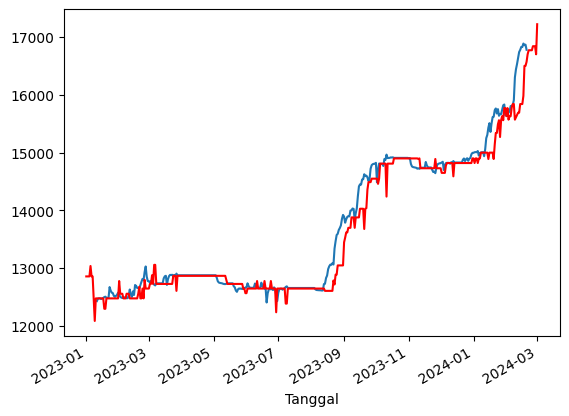

In [ ]:
plt.plot(jakarta_premium.index[window:-window],np.append(y_pred_train,y_pred_test))
jakarta_premium.plot(color='red')

###6.1.4 - Model Inference

In [ ]:
def forecasting(month):
  jakarta_premium_forecast = jakarta_premium.copy()
  window=10
  for i in range(month):
    X = jakarta_premium_forecast[-window:].values.reshape(1,-1)
    X_scaled = scaler.transform(X)
    new_idx = datetime(jakarta_premium_forecast.index.year[-1],jakarta_premium_forecast.index.month[-1]+1,1)
    jakarta_premium_forecast[new_idx] = round(model_lr.predict(X_scaled)[0])
  return jakarta_premium_forecast

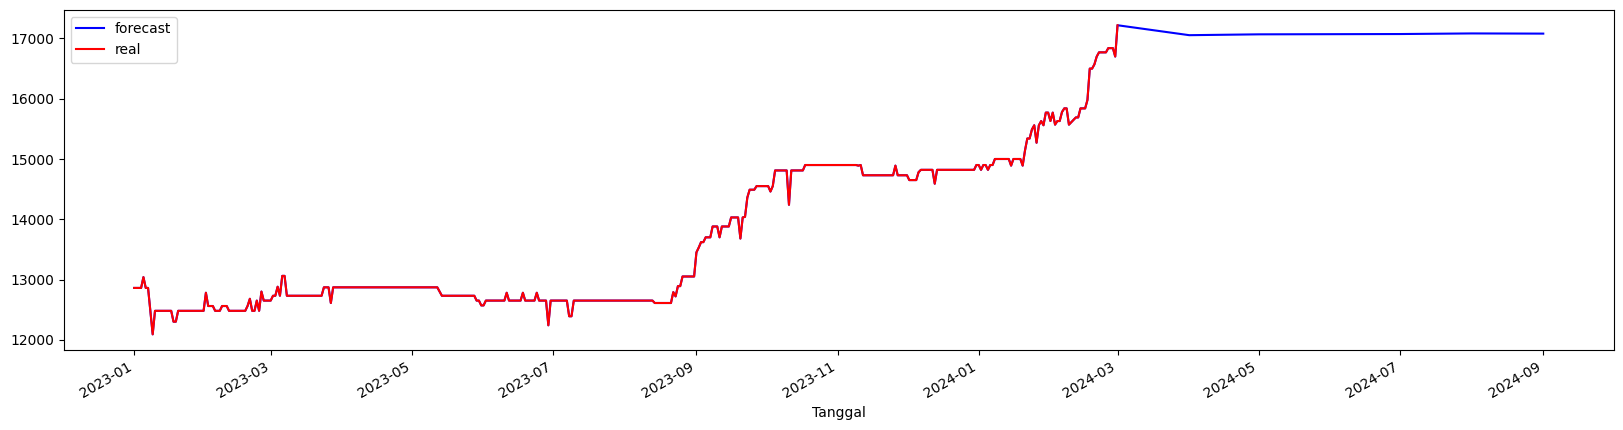

In [ ]:
jakarta_premium_forecast = forecasting(6)
jakarta_premium_forecast.plot(color='blue',label='forecast',figsize=(20,5))
jakarta_premium.plot(color='red',label='real')
plt.legend()

###6.1.5 - Model Conclusion

- The model has a Train MAE of 46.98520172724552 and Test MAE of 75.56469911191277, Train RMSE of ... and Test RMSE of ..., and finally Train Explained Variance Regression Score of ... and Test Explained Variance Regression Score of ...
- this means that the model can sufficiently predict the price with minimal difference than the actual data.
- Based on the model's inference for the next 6 months seems like it predicted that premium rice price will be stable.

##6.2 - Prophet

Prophet is a forecasting algorithm developed by Facebook for time series data. Quoting from https://facebook.github.io/prophet/ :

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

We will use Prophet algorithm using the guidelines provided in https://facebook.github.io/prophet/docs/quick_start.html#python-api.

In [ ]:
# Adding the index back to add the 'Tanggal' column back to the dataframe
df_prophet = jakarta_premium.reset_index()

In [ ]:
# Renaming the dataframe column to the appropriate name accepted by Prophet model
df_prophet = df_prophet.rename(columns={"Tanggal": "ds", "Harga": "y"})

In [ ]:
df_prophet.head()

,ds,y
0,2023-01-01,12860.0
1,2023-01-02,12860.0
2,2023-01-03,12860.0
3,2023-01-04,12860.0
4,2023-01-05,13040.0


In [ ]:
# Splitting data into training and testing sets
train_df, test_df = train_test_split(df_prophet, test_size=0.2, shuffle=False)

###6.2.1 - Model Definition

In [ ]:
# Define the Prophet model
model_prophet = Prophet()

###6.2.2 - Model Training

In [ ]:
# Fit the Prophet model
model_prophet.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfnprebgz/ip4rrai_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfnprebgz/f2zei9o2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5491', 'data', 'file=/tmp/tmpfnprebgz/ip4rrai_.json', 'init=/tmp/tmpfnprebgz/f2zei9o2.json', 'output', 'file=/tmp/tmpfnprebgz/prophet_model97ouiohy/prophet_model-20240307010952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:09:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:09:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Make predictions on the testing data
forecast = model_prophet.predict(test_df.drop(columns='y'))

###6.2.3 - Model Evaluation

In [ ]:
# Extracting true values and predicted values
true_values = test_df['y']
predicted_values = forecast['yhat']

In [ ]:
# Calculating MAE
mae = mean_absolute_error(true_values, predicted_values)

# Calculating RMSE
rmse = mean_squared_error(true_values, predicted_values)

print("Test MAE:", mae)
print("Test RMSE:", rmse)

Test MAE: 517.2293796742089
Test RMSE: 637153.2446818658


In [ ]:
print("Test data explained variance regression score:", explained_variance_score(true_values, predicted_values))

Test data explained variance regression score: 0.12748300864008844


In [ ]:
print("Train data R2 score:", r2_score(true_values, predicted_values))
print("Test data R2 score:", r2_score(true_values, predicted_values))

Train data R2 score: -0.38254677960192063
Test data R2 score: -0.38254677960192063


###6.2.4 - Model Inference (Range)

In [ ]:
future = model_prophet.make_future_dataframe(periods=182)
future.tail()

,ds
517,2024-06-01
518,2024-06-02
519,2024-06-03
520,2024-06-04
521,2024-06-05


In [ ]:
forecast = model_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
517,2024-06-01,15217.091925,11805.777380,18714.714838
518,2024-06-02,15206.262446,11747.559551,18778.227210
519,2024-06-03,15189.238028,11683.560817,18735.797635
520,2024-06-04,15201.635343,11696.211964,18754.060925
521,2024-06-05,15180.794763,11641.876957,18773.112201


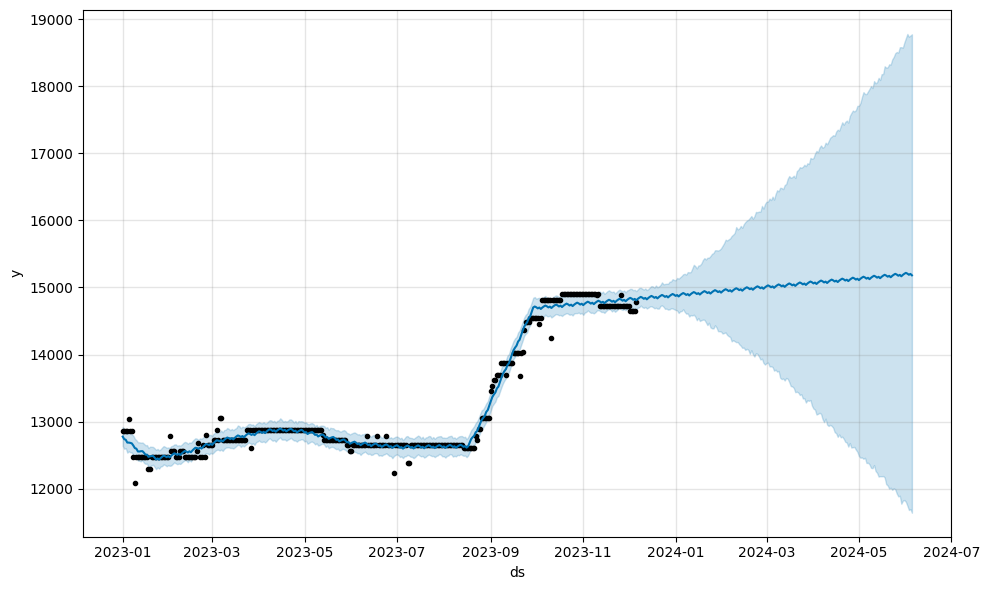

In [ ]:
fig1 = model_prophet.plot(forecast)

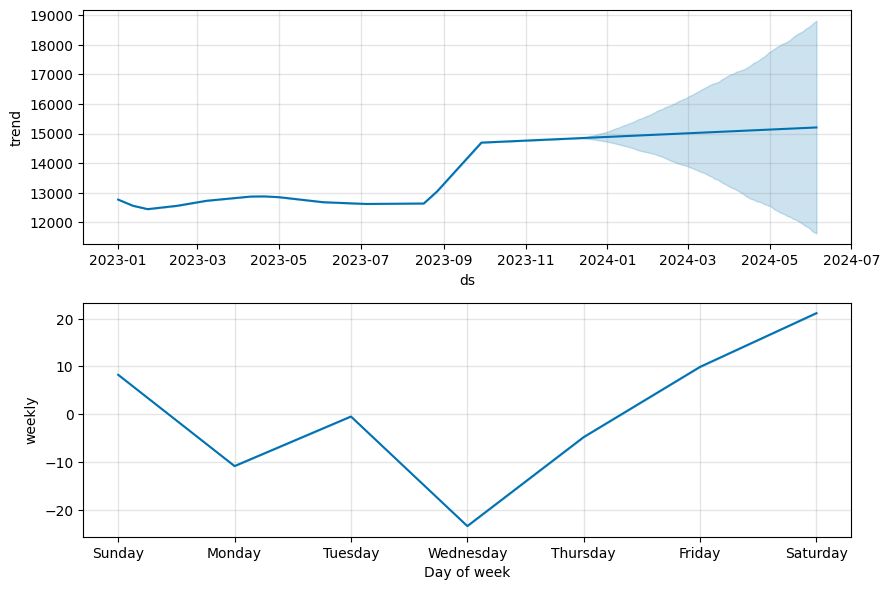

In [ ]:
fig2 = model_prophet.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_prophet, forecast)

###6.2.5 - Model Inference (single date)

In [ ]:
single_date = pd.DataFrame({'ds': ["2024-03-04"]}) #Prophet accepts YYYY-mm-dd format
forecast_single_date = model_prophet.predict(single_date)

In [ ]:
forecast_single_date[['ds', 'yhat']]

,ds,yhat
0,2024-03-04,15003.091026


##6.3 - Random Forest Regressor

###6.3.1 - Model Definition

In [ ]:
model_rf = RandomForestRegressor()

###6.3.2 - Model Training

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

###6.3.3 - Model Evaluation

In [ ]:
# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (neg_mean_squared_error):", grid_search.best_score_)

# Make predictions with the best model
best_rf_regressor = grid_search.best_estimator_
y_pred_train = best_rf_regressor.predict(X_train_scaled)
y_pred_test = best_rf_regressor.predict(X_test_scaled)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best Score (neg_mean_squared_error): -30169.559945386478


In [ ]:
print('Train MAE:',mean_absolute_error(y_train,y_pred_train))
print('Train RMSE:',mean_squared_error(y_train,y_pred_train))
print('-----------------------------------------------------')
print('Test MAE:',mean_absolute_error(y_test,y_pred_test))
print('Test RMSE:',mean_squared_error(y_test,y_pred_test))

Train MAE: 27.26021402230207
Train RMSE: 2779.724524711465
-----------------------------------------------------
Test MAE: 763.5512322232845
Test RMSE: 1010600.345268577


In [ ]:
print("Train data explained variance regression score:", explained_variance_score(y_train,y_pred_train))
print("Test data explained variance regression score:", explained_variance_score(y_test,y_pred_test))

Train data explained variance regression score: 0.9968721712572273
Test data explained variance regression score: 0.024990292573637718


In [ ]:
print("Train data R2 score:", r2_score(y_train,y_pred_train))
print("Test data R2 score:", r2_score(y_test,y_pred_test))

Train data R2 score: 0.9968712581779592
Test data R2 score: -1.2634822216298924


<Axes: xlabel='Tanggal'>

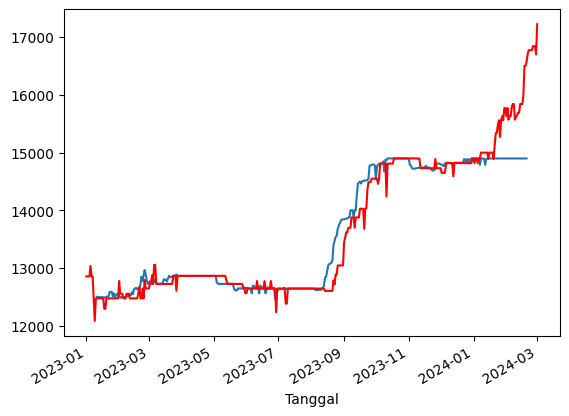

In [ ]:
plt.plot(jakarta_premium.index[window:-window],np.append(y_pred_train,y_pred_test))
jakarta_premium.plot(color='red')

###6.3.4 - Model Inference

In [ ]:
def forecasting(month):
  jakarta_premium_forecast = jakarta_premium.copy()
  window=10
  for i in range(month):
    X = jakarta_premium_forecast[-window:].values.reshape(1,-1)
    X_scaled = scaler.transform(X)
    new_idx = datetime(jakarta_premium_forecast.index.year[-1],jakarta_premium_forecast.index.month[-1]+1,1)
    jakarta_premium_forecast[new_idx] = round(best_rf_regressor.predict(X_scaled)[0])
  return jakarta_premium_forecast

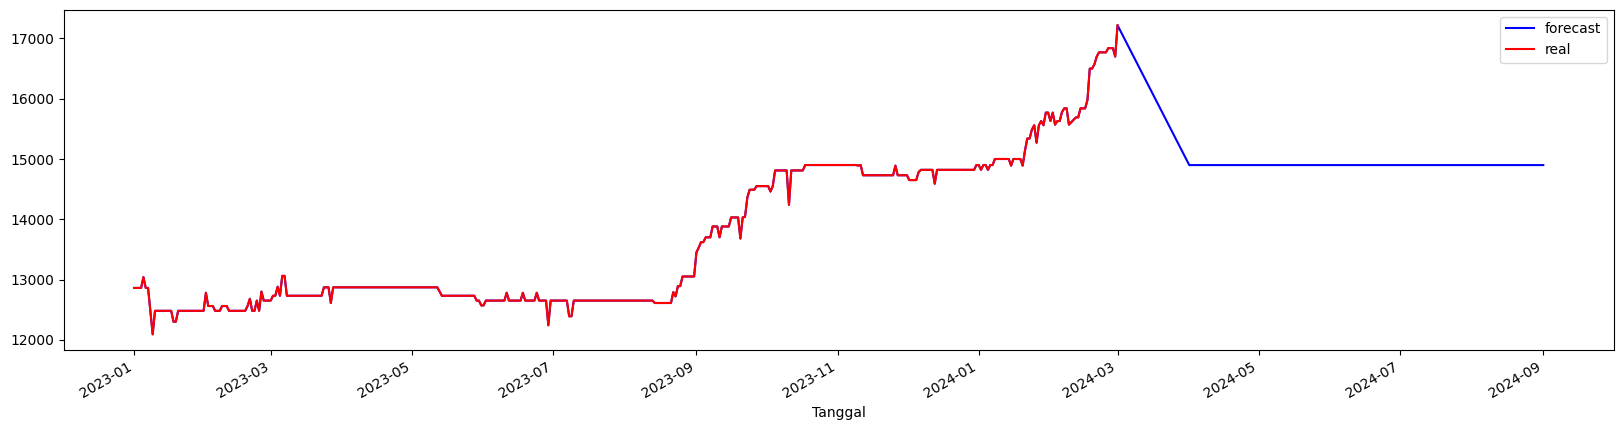

In [ ]:
jakarta_premium_forecast = forecasting(6)
jakarta_premium_forecast.plot(color='blue',label='forecast',figsize=(20,5))
jakarta_premium.plot(color='red',label='real')
plt.legend()

###6.3.5 - Model Conclusion

##6.4 - Linear Regression with Polynomial Features

###6.4.1 - Model Definition

The polynomial model stems from the linear regression model, but, its features converted into polynomial form.

In [ ]:
poly_model = LinearRegression()

###6.4.2 - Model Training

Pipeline will be introduced to process the training set:

1. convert into polynomial features,
2. transform with scaling, and
3. perform training on the model.

In [ ]:
X_train

array([[12480., 12480., 12480., ..., 12300., 12300., 12480.],
       [12480., 12480., 12480., ..., 12300., 12480., 12480.],
       [12480., 12480., 12480., ..., 12480., 12480., 12480.],
       ...,
       [14820., 14820., 14820., ..., 14820., 14820., 14820.],
       [14820., 14820., 14820., ..., 14820., 14820., 14820.],
       [14820., 14820., 14820., ..., 14820., 14820., 14820.]])

In [ ]:
# define the pipeline
polynomial_pipeline = Pipeline([
    # step 1: convert X_train into polynomial features
    ('convert_to_poly_features',PolynomialFeatures()),
    # step 2: scale the newly made features
    ('scaler', MinMaxScaler()),
    # step 3: train the model
    ('polynomial_regressor', LinearRegression())
])

# define the parameters (check which polynomial feature degree suits best)
parameter_grid = {
    'convert_to_poly_features__degree':[2,4,6,8],
    'scaler' : [StandardScaler()],
}

# initialize GridSearchCV with 5 times cross validations, scoring criteria explained variance score
poly_grid_search = GridSearchCV(polynomial_pipeline, parameter_grid, cv =5, scoring = 'explained_variance')

# fit the model
poly_grid_search.fit(X_train, y_train)

# get the best polynomial degree and best estimator
best_poly_degree = poly_grid_search.best_params_['convert_to_poly_features__degree']
poly_best_estimator = poly_grid_search.best_estimator_

# print the results
print("Best polynomial degree: ", best_poly_degree)
print("Best estimator: ", poly_best_estimator)

Best polynomial degree:  2
Best estimator:  Pipeline(steps=[('convert_to_poly_features', PolynomialFeatures()),
                ('scaler', StandardScaler()),
                ('polynomial_regressor', LinearRegression())])


In [ ]:
# fitting
poly_best_estimator.fit(X_train, y_train)

# predict the training set
y_pred_train_poly = poly_best_estimator.predict(X_train)

# Predict on the test set using the best estimator
y_test_pred_poly = poly_best_estimator.predict(X_test)


###6.4.4 - Model Evaluation

In [ ]:
print('Train MAE:',mean_absolute_error(y_train,y_pred_train_poly))
print('Train RMSE:',mean_squared_error(y_train,y_pred_train_poly, squared=False))
print('-----------------------------------------------------')
print('Test MAE:',mean_absolute_error(y_test,y_test_pred_poly))
print('Test RMSE:',mean_squared_error(y_test,y_test_pred_poly, squared=False))

Train MAE: 40.62348495564929
Train RMSE: 72.76979281406186
-----------------------------------------------------
Test MAE: 160.27140589671842
Test RMSE: 241.87341931250913


In [ ]:
print("Train data explained variance regression score:", explained_variance_score(y_train,y_pred_train_poly))
print("Test data explained variance regression score:", explained_variance_score(y_test,y_test_pred_poly))

Train data explained variance regression score: 0.9940396708238624
Test data explained variance regression score: 0.8860302307556168


In [ ]:
print("Train data R2 score:", r2_score(y_train,y_pred_train_poly))
print("Test data R2 score:", r2_score(y_test,y_test_pred_poly))

Train data R2 score: 0.9940396708238624
Test data R2 score: 0.8689690367148312


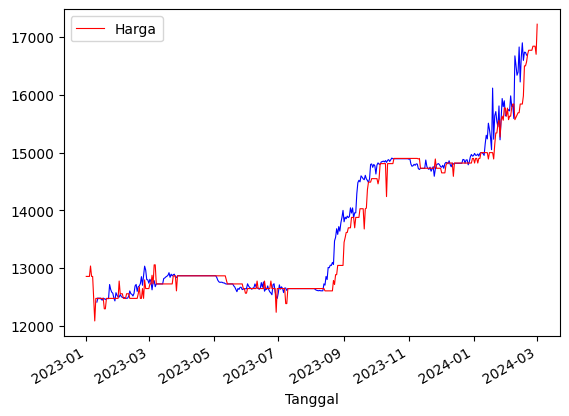

In [ ]:
plt.plot(jakarta_premium.index[window:-window],np.append(y_pred_train_poly,y_test_pred_poly), color = 'blue',linewidth = 0.8)
jakarta_premium.plot(color='red', linewidth = 0.8)
plt.legend()
plt.show()

###6.4.5 - Model Inference

In [ ]:
# create forecasting function
def forecasting_function(jakarta_premium, month, best_estimator):
    jakarta_premium_forecast = jakarta_premium.copy()
    window = 10

    for i in range(month):
        X = jakarta_premium_forecast[-window:].values.reshape(1, -1)
        # Predict the next value using the best estimator and round it
        next_value = round(best_estimator.predict(X)[0])
        # Extract the last date and add one month to it
        last_date = jakarta_premium_forecast.index[-1]
        new_date = last_date + timedelta(days=30)  # Add one month (approximation)
        # Append the predicted value to the forecast series with the new date index
        jakarta_premium_forecast.loc[new_date] = next_value

    return jakarta_premium_forecast

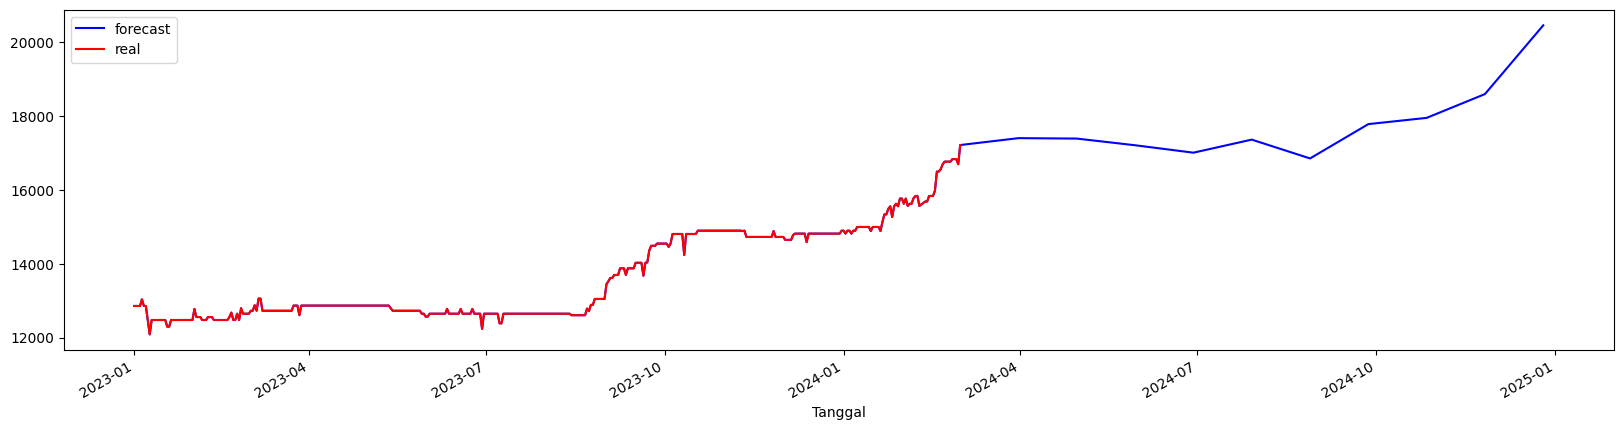

In [ ]:
jakarta_premium_forecast_poly = forecasting_function(jakarta_premium, 10,poly_best_estimator)
jakarta_premium_forecast_poly.plot(color='blue',label='forecast',figsize=(20,5))
jakarta_premium.plot(color='red',label='real')
plt.legend()

###6.4.6 - Model Conclusion

The Polynomial Linear Regression seems to have a decently high metric scores, and also create a more believeable prediction than without polynomial features.

##6.5 - Long Short Term Memory (LSTM)

###6.5.1 - Preprocessing Data

In [ ]:
jakarta = jakarta_premium.reset_index()
del jakarta['Tanggal']
scaler=MinMaxScaler(feature_range=(0,1))
jakarta_premium_scaled=scaler.fit_transform(np.array(jakarta).reshape(-1,1))
print(jakarta_premium_scaled.shape)

(426, 1)


In [ ]:
training_size=int(len(jakarta_premium_scaled)*0.60)
test_size=len(jakarta_premium_scaled)-training_size
train_data,test_data=jakarta_premium_scaled[0:training_size,:],jakarta_premium_scaled[training_size:len(jakarta_premium_scaled),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (255, 1)
test_data:  (171, 1)


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

###6.5.2 - Create X_train, X_test, y_train, and y_test

In [ ]:
time_step = 8
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (246, 8)
y_train:  (246,)
X_test:  (162, 8)
y_test (162,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (246, 8, 1)
X_test:  (162, 8, 1)


###6.5.3 - Model Definition

In [ ]:
tf.keras.backend.clear_session()
model_ltsm=Sequential()
model_ltsm.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model_ltsm.add(LSTM(32,return_sequences=True))
model_ltsm.add(LSTM(32))
model_ltsm.add(Dropout(0.20))
model_ltsm.add(Dense(1))
model_ltsm.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model_ltsm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 8, 32)             8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


###6.5.4 - Model Training

In [ ]:
history = model_ltsm.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=500,batch_size=16,verbose=1)

Epoch 1/500
16/16 [==============================] - 7s 73ms/step - loss: 0.0071 - val_loss: 0.1091
Epoch 2/500
16/16 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.1378
Epoch 3/500
16/16 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.1079
Epoch 4/500
16/16 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0647
Epoch 5/500
16/16 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0329
Epoch 6/500
16/16 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 7/500
16/16 [==============================] - 0s 11ms/step - loss: 9.0347e-04 - val_loss: 0.0249
Epoch 8/500
16/16 [==============================] - 0s 10ms/step - loss: 8.1404e-04 - val_loss: 0.0302
Epoch 9/500
16/16 [==============================] - 0s 13ms/step - loss: 9.0879e-04 - val_loss: 0.0168
Epoch 10/500
16/16 [==============================] - 0s 13ms/step - loss: 8.6630e-04 - 

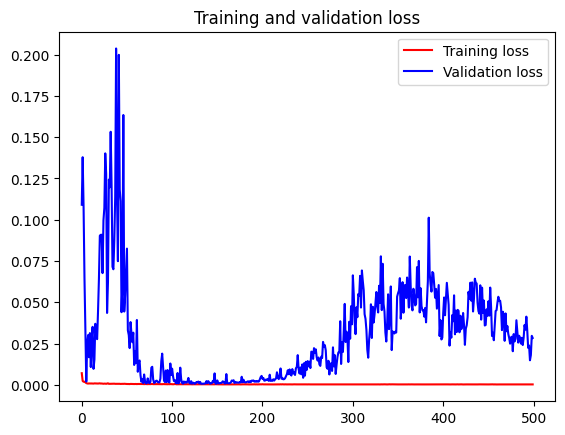

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model_ltsm.predict(X_train)
test_predict=model_ltsm.predict(X_test)
train_predict.shape, test_predict.shape

6/6 [==============================] - 0s 5ms/step


((246, 1), (162, 1))

###6.5.5 - Model Evaluation

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
print('Train MAE:',mean_absolute_error(original_ytrain,train_predict))
print('Train RMSE:',mean_squared_error(original_ytrain,train_predict, squared=False))
print('-----------------------------------------------------')
print('Test MAE:',mean_absolute_error(original_ytest,test_predict))
print('Test RMSE:',mean_squared_error(original_ytest,test_predict, squared=False))

Train MAE: 49.52666095020327
Train RMSE: 87.29534320420814
-----------------------------------------------------
Test MAE: 761.0403886959876
Test RMSE: 864.9017624670712


In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain,train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest,test_predict))

Train data explained variance regression score: 0.8937600244707232
Test data explained variance regression score: 0.5102515201822635


In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.8870193103622682
Test data R2 score: -1.1694393246827497


In [ ]:
jakarta_index = jakarta_premium.reset_index()

In [ ]:
# shift train predictions for plotting

import plotly.express as px
from itertools import cycle

look_back=time_step
trainPredictPlot = np.empty_like(jakarta_premium_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(jakarta_premium_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(jakarta_premium_scaled)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original price','Train predicted price','Test predicted price'])


plotdf = pd.DataFrame({'Tanggal': jakarta_index['Tanggal'],
                       'Harga': jakarta_index['Harga'],
                      'train_predicted_harga': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_harga': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Tanggal'], y=[plotdf['Harga'],plotdf['train_predicted_harga'],
                                          plotdf['test_predicted_harga']],
              labels={'value':'Harga','Tanggal': 'Tanggal'})
fig.update_layout(title_text='Comparision between original price vs predicted price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (426, 1)
Test predicted data:  (426, 1)


###6.5.7 - Model Inference

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model_ltsm.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_ltsm.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

1 day input [0.9122807  0.9122807  0.92592593 0.92592593 0.92592593 0.89863548
 1.         0.8261683 ]
1 day output [[0.17214142]]
[0.9122807017543861, 0.9122807017543861, 0.925925925925926, 0.925925925925926, 0.925925925925926, 0.8986354775828458, 1.0, 0.8261682987213135, 0.1721414178609848]
2 day input [0.9122807  0.92592593 0.92592593 0.92592593 0.89863548 1.
 0.8261683  0.17214142]
2 day output [[-0.06092183]]
[0.9122807017543861, 0.925925925925926, 0.925925925925926, 0.925925925925926, 0.8986354775828458, 1.0, 0.8261682987213135, 0.1721414178609848, -0.06092183291912079]
3 day input [ 0.92592593  0.92592593  0.92592593  0.89863548  1.          0.8261683
  0.17214142 -0.06092183]
3 day output [[-0.09566684]]
[0.925925925925926, 0.925925925925926, 0.925925925925926, 0.8986354775828458, 1.0, 0.8261682987213135, 0.1721414178609848, -0.06092183291912079, -0.09566684067249298]
4 day input [ 0.92592593  0.92592593  0.89863548  1.          0.8261683   0.17214142
 -0.06092183 -0.09566684]


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[1 2 3 4 5 6 7 8]
[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(jakarta_premium_scaled[len(jakarta_premium_scaled)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 7 days price','Predicted next 30 days price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 7 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
lstmdf=jakarta_premium_scaled.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['price'])

fig = px.line(lstmdf,labels={'value': 'price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='beras')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

###6.5.6 - Model Conclusion

The LTSM model, although having the highest metric scores, seems to fail the infrencing, as they predicted a sudden massive drop that seems unlikely based on the current trend.